# Setup
## Install necessary libs

In [2]:
!pip install tensorflow
!pip install opencv-python
!pip install scikit-learn
!pip install numpy
!pip install pandas
!pip install pympler
!pip install matplotlib

# Import libs

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import os
import sys
from pympler import asizeof
import matplotlib.pyplot as plt

In [3]:
# Check working path
working_path = os.getcwd()
working_path

'c:\\Users\\Shadow\\Documents\\Artificial Intelligence\\cifar10\\notebooks'

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict



In [3]:
batch1 = unpickle("../data/data_batch_1")
meta = unpickle("../data/batches.meta")

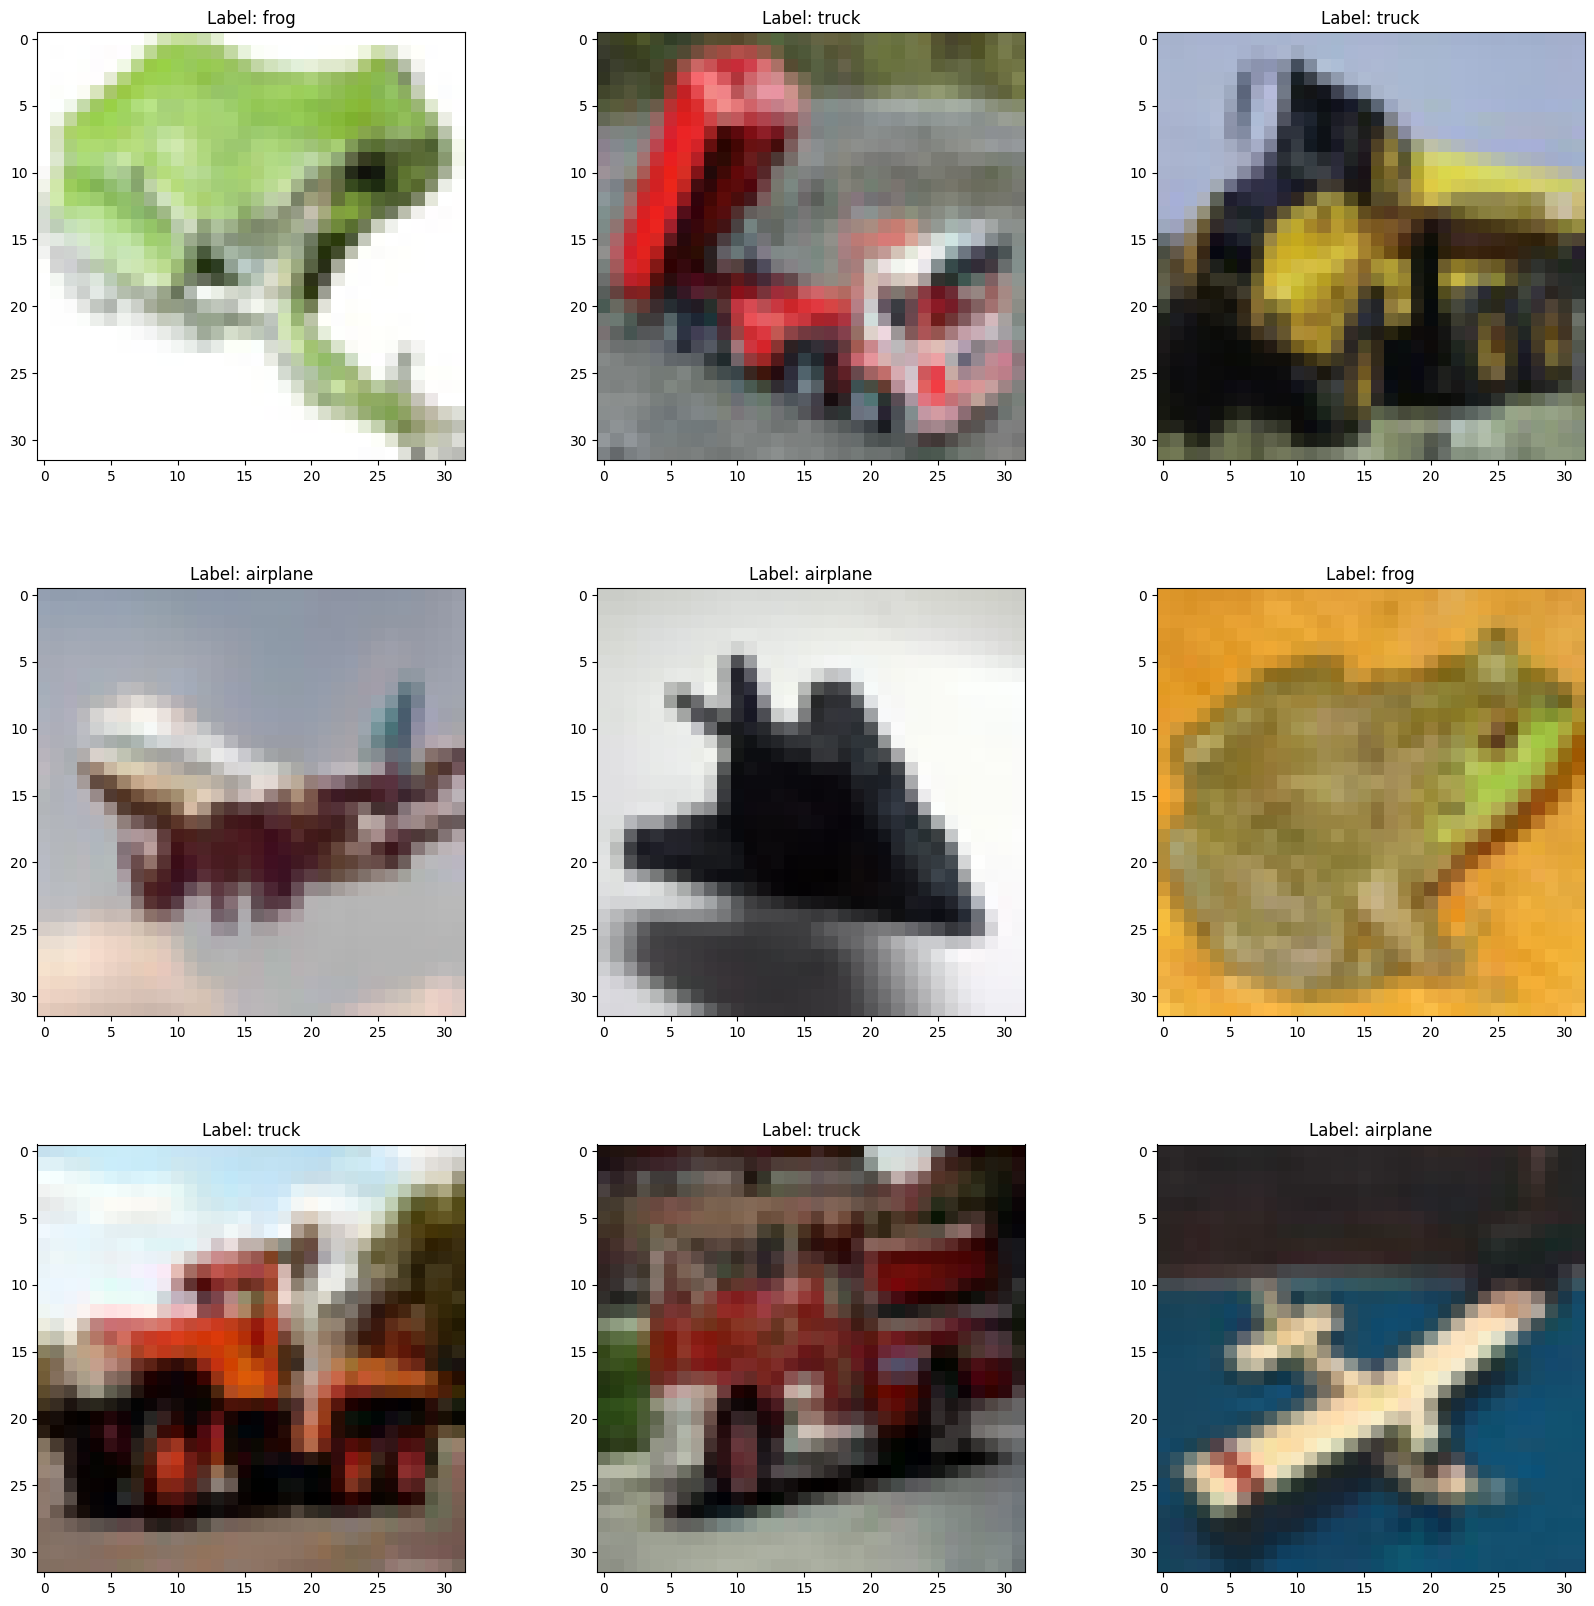

In [4]:
def display_images(batch, metadata):
    batch_images = batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    labels =  pd.DataFrame({"name": metadata[b'label_names'], 
              "id": [i for i in range(len(metadata[b'label_names']))]}).set_index('id')

    num_img = 9

    fig, axes = plt.subplots(3, 3, figsize=(20,20))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i in range(num_img):
        idx = np.random.randint(metadata[b'num_cases_per_batch'])
        ax = axes[i // 3, i % 3]
        ax.imshow(batch_images[idx])
        ax.set_title(f"Label: {labels.loc[batch[b'labels'][idx]].values[0].decode('ascii')}")
    plt.show()

display_images(batch1,meta)

## Quick EDA (Repartition of classes, etc...)

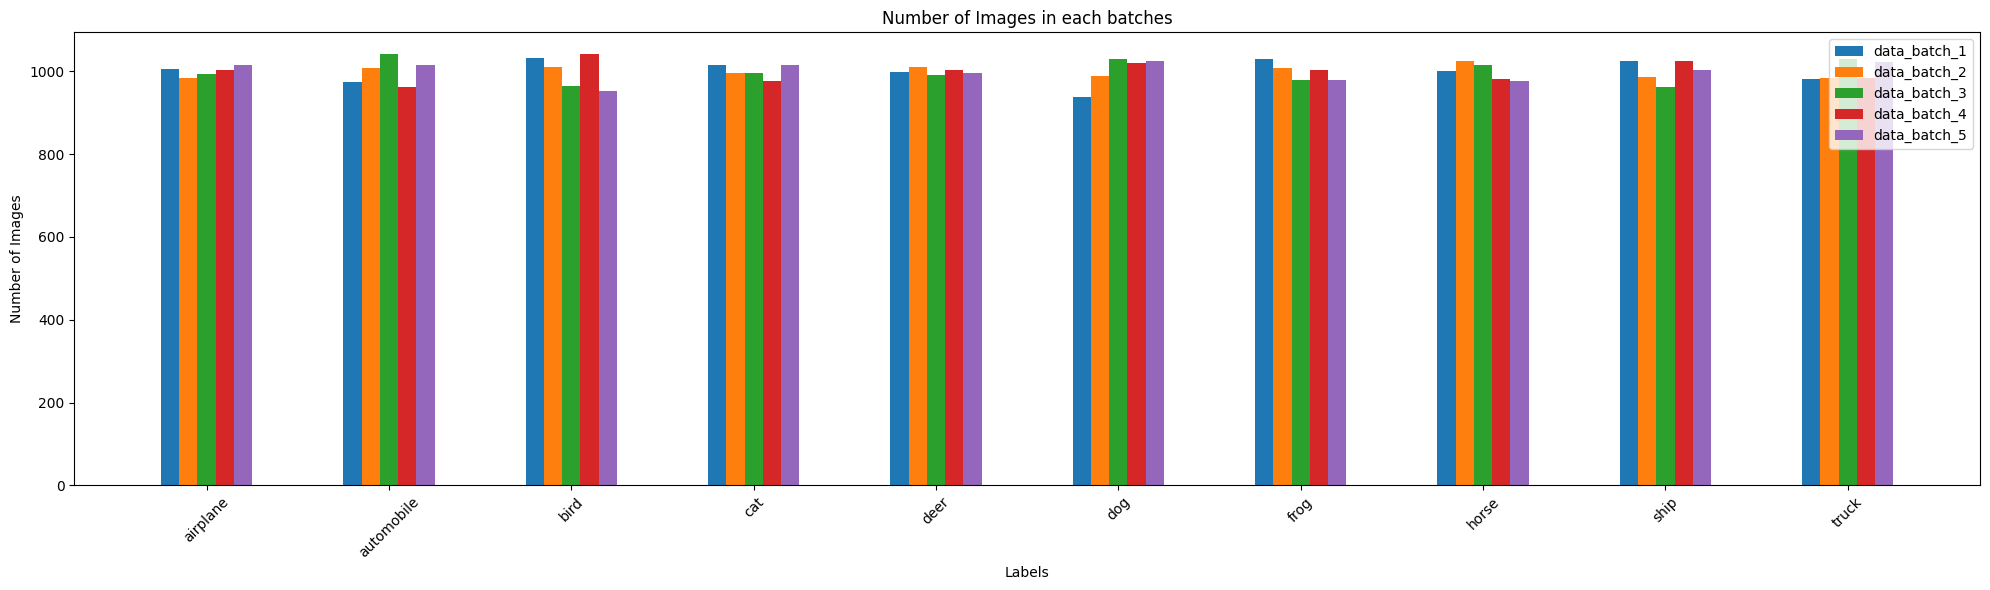

In [47]:
labels = pd.DataFrame({"name": [ i.decode('ascii') for i in meta[b'label_names']], 
            "id": [i for i in range(len(meta[b'label_names']))]})

def compute_batch_repartition(batch, name):
    l = batch[b'labels']
    lc  = [0 for i in range(10)]
    for i in l:
        lc[i] += 1
    return {"name": name, "distribution": lc}

batches_path = ["../data/data_batch_1","../data/data_batch_2","../data/data_batch_3","../data/data_batch_4","../data/data_batch_5"]
batches_distrib = [compute_batch_repartition(unpickle(i), i.split("/")[-1]) for i in batches_path]

plt.figure(figsize=(20,6))
X = labels["name"]
bar_width = 0.1
xaxis = np.arange(len(X))

for i in range(len(batches_distrib)):
    x = xaxis + i * bar_width
    plt.bar(x, batches_distrib[i]['distribution'], bar_width, label = batches_distrib[i]['name'])

plt.xticks(xaxis + bar_width * (len(batches_distrib) - 1) / 2, X, rotation=45)
plt.xlabel("Labels")
plt.ylabel("Number of Images")
plt.title("Number of Images in each batches")
plt.legend()
plt.tight_layout()
plt.show()


We can obersve difference, we might want to 

## Preprocess

In [5]:
batches_path = ["../data/data_batch_1","../data/data_batch_2","../data/data_batch_3","../data/data_batch_4","../data/data_batch_5"]

def simple_preprocess(unpickled_batch):
    # This shape is given by cifar dataset
    unpickled_batch[b'data'] = unpickled_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return unpickled_batch

def simple_preprocess_xy(unpickled_batch):
    unpickled_batch[b'data'] = unpickled_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return tf.convert_to_tensor(unpickled_batch[b'data']), tf.convert_to_tensor(unpickled_batch[b'labels']) 



## Training

In [72]:
from tensorflow.keras import layers

def create_model():
        
    input_shape = (32, 32, 3)
    num_classes = 10

    model = tf.keras.Sequential(
        [
            layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
            layers.MaxPooling2D((2,2)),
            layers.Conv2D(64, (3,3), activation='relu'),
            layers.MaxPooling2D((2,2)),
            layers.Conv2D(128, (3,3), activation='relu'),
            layers.MaxPooling2D((2,2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation='softmax')
        ]
    )
    model.compile(optimizer='sgd',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model


def training_loop(model):
    for i in batches_path:
        b = simple_preprocess(unpickle(i))
        x = tf.convert_to_tensor(b[b'data'])
        y = tf.convert_to_tensor(b[b'labels'])
        model.fit(x,y, batch_size=32, epochs=10)


model = create_model()
training_loop(model)

c:\Users\Shadow\anaconda3\envs\CIFAR-TF\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.1151 - loss: 12.0493
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1351 - loss: 2.2739
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1617 - loss: 2.2457
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1833 - loss: 2.2112
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1892 - loss: 2.1863
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2035 - loss: 2.1777
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2260 - loss: 2.0967
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2389 - loss: 2.0672
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2307 - loss: 2.0850
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2705 - loss: 1.9935
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2651 - loss: 2.0037
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3

## Dev and test 

In [70]:
def test(model):
    x, y = simple_preprocess_xy(unpickle("../data/test_batch"))
    loss = model.evaluate(x,y)
    return loss
loss = test(model)
loss

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5806 - loss: 1.2233


[1.2275935411453247, 0.5752000212669373]

## Fine-tune & Analysis

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def create_model(optimizer='adam', init_form='uniform', activation='relu', loss='sparse_categorical_crossentropy', dropout=0.5):
        
    input_shape = (32, 32, 3)
    num_classes = 10

    model = tf.keras.Sequential(
        [
            layers.Conv2D(32, (3,3), activation=activation, kernel_initializer=init_form, input_shape=input_shape),
            layers.MaxPooling2D((2,2)),
            layers.Conv2D(64, (3,3), activation=activation),
            layers.MaxPooling2D((2,2)),
            layers.Conv2D(128, (3,3), activation=activation),
            layers.MaxPooling2D((2,2)),
            layers.Flatten(),
            layers.Dense(128, activation=activation),
            layers.Dropout(dropout),
            layers.Dense(num_classes, activation='softmax')
        ]
    )
    model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)
param_dist = {
    "optimizer": ['adam', 'rmsprop'],
    "init_mode": ["uniform", "lecun_uniform", "normal"],
    "activation": ["relu", "tanh"],
    "epochs": [1,5,10,15,20],
    "batch_size": [8,16,32]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, scoring='accuracy', n_jobs=-1, cv=3)
random_search.fit(x,y)
